In [1]:
import cv2
from cv2 import aruco# Needs opencv-contrib-python==4.6.0.66
import os
import numpy as np
import matplotlib.pyplot as plt

### Old API

In [2]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_4X4_250)
# board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
board = aruco.CharucoBoard_create(6, 4, 1, 0.5, aruco_dict)
imboard = board.draw((2000, 2000))

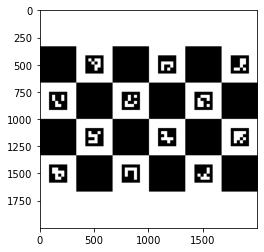

In [60]:
plt.imshow(imboard, cmap='gray')
plt.show()

### Read images and resize them to have the same size

In [4]:
datadir_left = "./images/left/calibration/"
datadir_front = "./images/front/calibration/"
datadir_right = "./images/right/calibration/"

image_paths_left = np.array([datadir_left + f for f in os.listdir(datadir_left) if f.endswith(".JPG") ])
image_paths_front = np.array([datadir_front + f for f in os.listdir(datadir_front) if f.endswith(".JPG") ])
image_paths_right = np.array([datadir_right + f for f in os.listdir(datadir_right) if f.endswith(".JPG") ])

image_paths_left=sorted(image_paths_left)
image_paths_front=sorted(image_paths_front)
image_paths_right=sorted(image_paths_right)

In [5]:
len(image_paths_left), len(image_paths_front), len(image_paths_right)

(7, 7, 7)

In [6]:
img_left = cv2.imread(image_paths_left[0])
print("Left image shape: ", img_left.shape)

img_front = cv2.imread(image_paths_front[0])
print("Front image shape: ", img_front.shape)

img_right = cv2.imread(image_paths_right[0])
print("Right image shape: ", img_right.shape)

Left image shape:  (4872, 5568, 3)
Front image shape:  (4872, 5568, 3)
Right image shape:  (4176, 5568, 3)


In [7]:
images_left_uncut = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths_left]
images_front_uncut = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths_front]
images_right_uncut = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in image_paths_right]

Testing detections on different crops

In [76]:
### DEBUG ###

for i, (image_l, image_f, image_r) in enumerate(zip(images_left_uncut, images_front_uncut, images_right_uncut)):
    print("Image number: ", i)
    
    # two options: like this from 500 to 1500 for the second dimension start
    image_l = image_l[1000:4150, 1300:4450, :]
    image_f = image_f[1000:4150, 1300:4450, :]
    image_r = image_r[1000:4150, 1300:4450, :]

    gray = cv2.cvtColor(image_l, cv2.COLOR_RGB2GRAY)
    markers, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
    print("Left: ", len(markers))
    
    gray = cv2.cvtColor(image_f, cv2.COLOR_RGB2GRAY)
    markers, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
    print("Front: ", len(markers))
    
    gray = cv2.cvtColor(image_r, cv2.COLOR_RGB2GRAY)
    markers, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
    print("Right: ", len(markers))
    
    plt.imshow(image_l)
    plt.show()
    plt.imshow(image_f)
    plt.show()
    plt.imshow(image_r)
    plt.show()

NameError: name 'images_left_uncut' is not defined

In [8]:
images_left_full = [img[1000:4150, 1300:4450, :].copy() for img in images_left_uncut]
images_front_full = [img[1000:4150, 1300:4450, :].copy() for img in images_front_uncut]
images_right_full = [img[1000:4150, 1300:4450, :].copy() for img in images_right_uncut]

# images_left = [cv2.resize(img[1000:4150, 1300:4450, :], (0,0), fx=0.85, fy=0.85) for img in images_left_uncut]
# images_front = [cv2.resize(img[1000:4150, 1300:4450, :], (0,0), fx=0.85, fy=0.85) for img in images_front_uncut]
# images_right = [cv2.resize(img[1000:4150, 1300:4450, :], (0,0), fx=0.85, fy=0.85) for img in images_right_uncut]

assert images_left_full[0].shape==images_front_full[0].shape==images_right_full[0].shape
imsize = images_right_full[0].shape[0:2]

In [9]:
imsize

(3150, 3150)

In [10]:
del images_left_uncut
del images_front_uncut
del images_right_uncut

this works better

In [11]:
index = 1
images_left = [images_left_full[index]]
images_front = [images_front_full[index]]
images_right = [images_right_full[index]]

### Markers + corners

In [12]:
def read_chessboards(images, addEmpty=False):
    """
    Finding corners on a chessboard
    """
    chessCorners = []
    chessCornersIds = []
    
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for i, image in enumerate(images):
        print("=> Processing image {0}".format(i))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        markers, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        print("Number of markers detected: ", len(markers))

        if len(markers)>0:
            # SUB PIXEL DETECTION
            for marker in markers:
                # check whether this one is called correctly
                cv2.cornerSubPix(gray, marker,
                                 winSize = (3,3),
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
                
            res2 = cv2.aruco.interpolateCornersCharuco(markers, ids, gray, board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3:
                chessCorners.append(res2[1])
                chessCornersIds.append(res2[2])
            elif addEmpty:
                chessCorners.append(np.array([]))
                chessCornersIds.append(np.array([]))
        elif addEmpty:
            chessCorners.append(np.array([]))
            chessCornersIds.append(np.array([]))
#         print(len(chessCorners))

    return chessCorners, chessCornersIds

In [78]:
print("LEFT IMAGES")
allCorners_left, allIds_left = read_chessboards(images_left)
print("FRONT IMAGES")
allCorners_front, allIds_front = read_chessboards(images_front)
print("RIGHT IMAGES")
allCorners_right, allIds_right = read_chessboards(images_right)

LEFT IMAGES
=> Processing image 0
Number of markers detected:  10
FRONT IMAGES
=> Processing image 0
Number of markers detected:  12
RIGHT IMAGES
=> Processing image 0
Number of markers detected:  11


### Camera calibration

In [14]:
def calibrate_camera(allCorners, allIds):
    """
    Calibrates the camera using the dected corners.
    """
    cameraMatrixInit = np.array([[ 3150.,    0., imsize[0]/2.],
                                 [    0., 3150., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
#     flags = (cv2.CALIB_RATIONAL_MODEL)
    
#     (ret, camera_matrix, distortion_coefficients0,
#      rotation_vectors, translation_vectors,
#      stdDeviationsIntrinsics, stdDeviationsExtrinsics,
#      perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
#                       charucoCorners=allCorners,
#                       charucoIds=allIds,
#                       board=board,
#                       imageSize=imsize,
#                       cameraMatrix=cameraMatrixInit,
#                       distCoeffs=distCoeffsInit,
#                       flags=flags,
#                       criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))
    
    ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors = aruco.calibrateCameraCharuco(
        charucoCorners=allCorners,
        charucoIds=allIds,
        board=board,
        imageSize=imsize,
        cameraMatrix=cameraMatrixInit,
        distCoeffs=None,
        flags=flags,
        criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9)
    )

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [15]:
calibration_parameters = {}

# results are ret, mtx, dist, rvecs, tvecs
res_left = calibrate_camera(allCorners_left, allIds_left)
print("Left camera calibration accuracy: ", res_left[0])
calibration_parameters['left'] = res_left

res_front = calibrate_camera(allCorners_front, allIds_front)
print("Front camera calibration accuracy: ", res_front[0])
calibration_parameters['front'] = res_front

res_right = calibrate_camera(allCorners_right, allIds_right)
print("Right camera calibration accuracy: ", res_right[0])
calibration_parameters['right'] = res_right

Left camera calibration accuracy:  0.13991297802096883
Front camera calibration accuracy:  0.153912513836919
Right camera calibration accuracy:  0.23172296131392542


In [ ]:
### DEBUG ###

for img, corners, ids in zip(images_right, allCorners_right, allIds_right):
    for corner, c_id in zip(corners, ids):
        print(corner, c_id)
        c = img.copy()
        
        c = cv2.circle(c, (int(corner[0][0]), int(corner[0][1])), 10, (255, 0, 0), 5)
    
        plt.imshow(c)
        plt.show()

### Stereo calibration

In [16]:
print("LEFT IMAGES")
allCorners_left, allIds_left = read_chessboards(images_left, addEmpty=True)
print("FRONT IMAGES")
allCorners_front, allIds_front = read_chessboards(images_front, addEmpty=True)
print("RIGHT IMAGES")
allCorners_right, allIds_right = read_chessboards(images_right, addEmpty=True)

LEFT IMAGES
=> Processing image 0
Number of markers detected:  10
FRONT IMAGES
=> Processing image 0
Number of markers detected:  12
RIGHT IMAGES
=> Processing image 0
Number of markers detected:  11


In [17]:
def get_common_corners_and_objpoints(allCorners_first, allIds_first, allCorners_second, allIds_second):
    corners1 = []
    corners2 = []
    objpoints = []
    
    i = 0
    for corners_first, ids_first, corners_second, ids_second in zip(allCorners_first, allIds_first, allCorners_second, allIds_second):
        common_ids = set(ids_first.flatten()).intersection(ids_second.flatten())
        
        if len(common_ids) == 0:
            print(f"No corners retrieved in the {i} image")
            i += 1
            continue
        
        print(f"Corners retrieved in the {i} image", common_ids)
        i += 1
        
        objp = []
        for c_id in common_ids:
            # first row then columns or vice-versa
            x = c_id % 5
            y = c_id // 5
            
            objp.append([float(x), float(y), 0.0])
        objpoints.append(np.array(objp, dtype=np.float32))
            
        mask1 = list(map(lambda x: x[0] in common_ids, ids_first))
        mask2 = list(map(lambda x: x[0] in common_ids, ids_second))
        
        corners1.append(corners_first[mask1].squeeze(1))
        corners2.append(corners_second[mask2].squeeze(1))
        
        assert(len(corners_first[mask1])==len(corners_second[mask2])==len(objp))
        
    return corners1, corners2, objpoints
    

In [18]:
stereo_results = {}

In [19]:
corners_front_L, corners_left, objpoints_L = get_common_corners_and_objpoints(
    allCorners_front, 
    allIds_front,
    allCorners_left, 
    allIds_left, 
)

Corners retrieved in the 0 image {0, 1, 2, 3, 4, 5, 6, 9, 11, 14}


In [20]:
ret, mat1, dist1, mat2, dist2, r,t, e, f = cv2.stereoCalibrate(
    objpoints_L, 
    corners_front_L, 
    corners_left, 
    calibration_parameters['front'][1],
    calibration_parameters['front'][2],
    calibration_parameters['left'][1], 
    calibration_parameters['left'][2],
    imsize
)
stereo_results['front-left'] = [ret, mat1, dist1, mat2, dist2, r,t, e, f]
[ret, mat1, dist1, mat2, dist2, r,t, e, f]

[0.45837651879543817,
 array([[2.91167579e+03, 0.00000000e+00, 1.64979047e+03],
        [0.00000000e+00, 2.91167579e+03, 1.55604693e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-2.81555695e-01, -4.27912446e+00, -1.14097463e-01,
         -3.12666224e-02,  9.58595829e+01]]),
 array([[3.06502691e+03, 0.00000000e+00, 1.56726013e+03],
        [0.00000000e+00, 3.06502691e+03, 1.56798653e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-0.36173302, -1.56581615, -0.19303805,  0.03695501, -6.25797845]]),
 array([[ 0.84029728, -0.04114902, -0.54056197],
        [ 0.04444968,  0.99898746, -0.00694907],
        [ 0.54030058, -0.01818852,  0.8412755 ]]),
 array([[26.14884974],
        [-0.92225154],
        [10.09396186]]),
 array([[ -0.94696643, -10.06696689,  -0.70572393],
        [ -5.64630992,   0.06025226, -27.45479854],
        [  1.93727351,  26.08442312,  -0.6802444 ]]),
 array([[ 1.78115773e-08,  1.89350491e-07, -2.85373963e-04],
    

In [21]:
corners_front_R, corners_right, objpoints_R = get_common_corners_and_objpoints(
    allCorners_front, 
    allIds_front,
    allCorners_right, 
    allIds_right, 
)

Corners retrieved in the 0 image {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [22]:
ret, mat1, dist1, mat2, dist2, r,t, e, f = cv2.stereoCalibrate(
    objpoints_R, 
    corners_front_R, 
    corners_right, 
    calibration_parameters['front'][1],
    calibration_parameters['front'][2],
    calibration_parameters['right'][1], 
    calibration_parameters['right'][2],
    imsize
)
stereo_results['front-right'] = [ret, mat1, dist1, mat2, dist2, r,t, e, f]
[ret, mat1, dist1, mat2, dist2, r,t, e, f]

[0.3038102540397866,
 array([[2.91167579e+03, 0.00000000e+00, 1.64979047e+03],
        [0.00000000e+00, 2.91167579e+03, 1.55604693e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-2.81555695e-01, -4.27912446e+00, -1.14097463e-01,
         -3.12666224e-02,  9.58595829e+01]]),
 array([[3.39920046e+03, 0.00000000e+00, 1.55205688e+03],
        [0.00000000e+00, 3.39920046e+03, 1.53314573e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 array([[-0.05176024, -0.02136314,  0.05870754,  0.03663023,  0.98862902]]),
 array([[ 0.71958242, -0.03634098,  0.69345546],
        [ 0.21421375,  0.96154294, -0.1718943 ],
        [-0.66054039,  0.27223981,  0.69969413]]),
 array([[-26.96328977],
        [ -1.92717137],
        [ 13.8957244 ]]),
 array([[ -1.70368075, -13.88598841,   1.04016528],
        [ -7.81122288,   6.83549667,  28.50212157],
        [ -4.38914885, -25.99639611,   5.97124327]]),
 array([[-3.55423970e-08, -2.89691196e-07,  5.72594132e-04],
  

In [24]:
#projection matrix for front camera is identity
projection_front = calibration_parameters['front'][1] @ np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1) 
 
#projection matrix for left camera is the R and T obtained from stereo calibration
projection_left = calibration_parameters['left'][1] @ np.concatenate([r, t], axis = -1) 

In [ ]:
### DEBUG ###

img_left = images_left[0].copy()
img_front = images_front[0].copy()

for c1, c2 in zip(corners1[0], corners2[0]):
    color = tuple(np.random.randint(0, 255, 3).tolist())
    img_front = cv2.circle(img_front, (int(c1[0]), int(c1[1])), 25, color, -1)
    img_left = cv2.circle(img_left, (int(c2[0]), int(c2[1])), 25, color, -1)
    
plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(img_front)
plt.show()

plt.figure(figsize=(16, 12), dpi=80)
plt.imshow(img_left)
plt.show()

### Epipolar lines using calibration board

In [25]:
def drawlines(img1, img2, lines, pts1, pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r, c, _ = img1.shape

    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = (0, 255, 255)
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 10)
        img1 = cv2.circle(img1, (int(pt1[0]), int(pt1[1])), 25, color, -1)
        img2 = cv2.circle(img2, (int(pt2[0]), int(pt2[1])), 25, color, -1)
    return img1, img2

In [84]:
points_front = allCorners_front[0].reshape(-1, 1, 2)
points_right = allCorners_right[0].reshape(-1, 1, 2)
points_left = allCorners_left[0].reshape(-1, 1, 2)

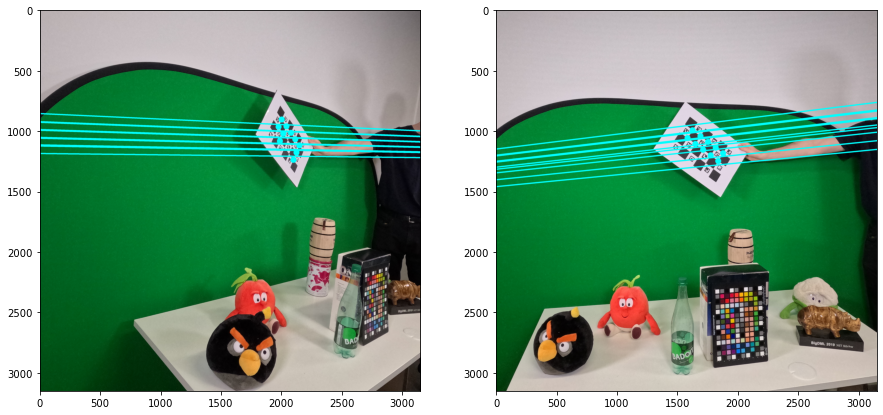

In [85]:
lines_2 = cv2.computeCorrespondEpilines(points_left, 2,  stereo_results['front-left'][-1]) #fundamental matrix
lines_2 = lines_2.reshape(-1, 3)

img2, _ = drawlines(
    images_front[0].copy(), 
    images_left[0].copy(), 
    lines_2, 
    points_front.reshape(-1,2), 
    points_left.reshape(-1,2)
)
img_front_unrect_L = img2

lines_1 = cv2.computeCorrespondEpilines(points_front, 1, stereo_results['front-left'][-1]) #fundamental matrix
lines_1 = lines_1.reshape(-1, 3)

img1, _ = drawlines(
    images_left[0].copy(), 
    images_front[0].copy(), 
    lines_1, 
    points_left.reshape(-1,2),
    points_front.reshape(-1,2), 
)
img_left_unrect = img1

fig, axarr = plt.subplots(1,2, figsize=(15, 15))

axarr[0].imshow(img1)
axarr[1].imshow(img2)
plt.show()

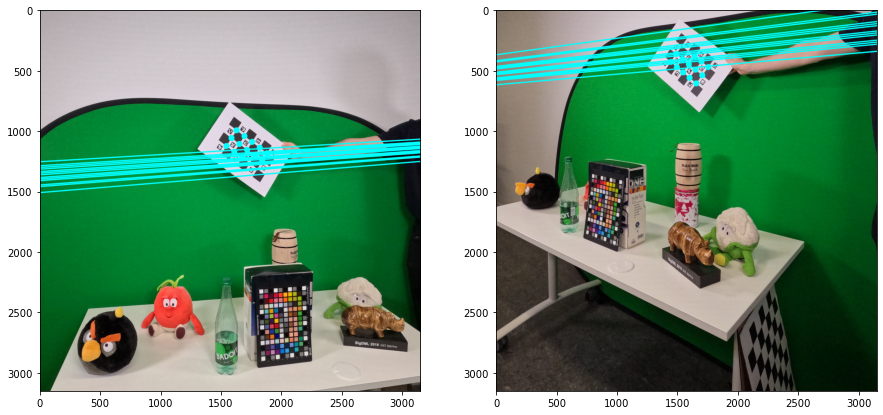

In [87]:
lines_2 = cv2.computeCorrespondEpilines(points_right, 2, stereo_results['front-right'][-1]) #fundamental matrix
lines_2 = lines_2.reshape(-1, 3)

img2, _ = drawlines(
    images_front[0].copy(), 
    images_right[0].copy(), 
    lines_2, 
    points_front.reshape(-1,2), 
    points_right.reshape(-1,2)
)
img_front_unrect_R = img2

lines_1 = cv2.computeCorrespondEpilines(points_front, 1, stereo_results['front-right'][-1]) #fundamental matrix
lines_1 = lines_1.reshape(-1, 3)

img1, _ = drawlines(
    images_right[0].copy(), 
    images_front[0].copy(), 
    lines_1, 
    points_right.reshape(-1,2),
    points_front.reshape(-1,2), 
)
img_right_unrect = img1

fig, axarr = plt.subplots(1,2, figsize=(15, 15))

axarr[0].imshow(img2)
axarr[1].imshow(img1)
plt.show()

### rectification without sift

In [29]:
def rectify_simple(stereo_key, calib_key_1, calib_key_2, img_1, img_2):
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
        calibration_parameters[calib_key_1][1], #mtx1 
        calibration_parameters[calib_key_1][2], #dst1
        calibration_parameters[calib_key_2][1], #mtx2
        calibration_parameters[calib_key_2][2], #dst2
        imsize, 
        stereo_results[stereo_key][5], # r 
        stereo_results[stereo_key][6], # t
    )
    
    map11, map12 = cv2.initUndistortRectifyMap(
        calibration_parameters[calib_key_1][1], #mtx1 
        calibration_parameters[calib_key_1][2], #dst1
        R1, 
        P1, 
        imsize, 
        cv2.CV_32FC1);

    map21, map22 = cv2.initUndistortRectifyMap(
        calibration_parameters[calib_key_2][1], #mtx2
        calibration_parameters[calib_key_2][2], #dst2
        R2, 
        P2, 
        imsize, 
        cv2.CV_32FC1);

    img1 = cv2.remap(img_1, map11, map12, cv2.INTER_LINEAR);
    img2 = cv2.remap(img_2, map21, map22, cv2.INTER_LINEAR);
    
    return Q, img1, img2

In [89]:
Q_fl, img1, img2 = rectify_simple('front-left', 'front', 'left', img_front_unrect_L, img_left_unrect)

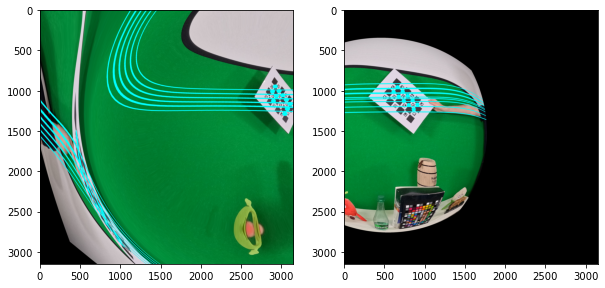

In [90]:
fig, axarr = plt.subplots(1,2, figsize=(10, 10))

axarr[0].imshow(img2)
axarr[1].imshow(img1)
plt.show()

In [92]:
Q_fr, img1, img2 = rectify_simple('front-right', 'front', 'right', img_front_unrect_R, img_right_unrect)

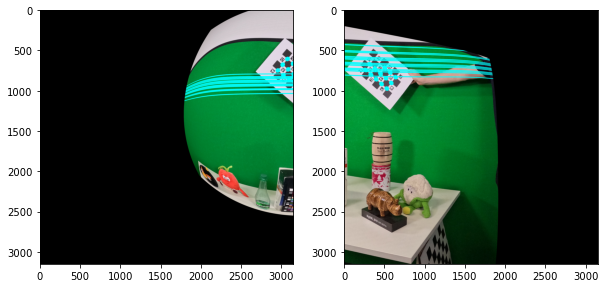

In [93]:
fig, axarr = plt.subplots(1,2, figsize=(10, 10))

axarr[0].imshow(img1)
axarr[1].imshow(img2)
plt.show()

### rectification with sift

Brute force based matching method

(Try to test Flann based method later to see if it is better/worse)

 Lowes ratio
[this is a good explanation of Lowes ratio](https://stackoverflow.com/questions/51197091/how-does-the-lowes-ratio-test-work)

In [34]:
image_front_new = cv2.cvtColor(cv2.imread('./images/front/capture1.JPG'), cv2.COLOR_BGR2RGB)
image_left_new = cv2.cvtColor(cv2.imread('./images/left/capture1.JPG'), cv2.COLOR_BGR2RGB)
image_right_new = cv2.cvtColor(cv2.imread('./images/right/capture1.JPG'), cv2.COLOR_BGR2RGB)

image_front_new = image_front_new[1000:4150, 1300:4450, :]
image_left_new = image_left_new[1000:4150, 1300:4450, :]
image_right_new = image_right_new[1000:4150, 1300:4450, :]

In [35]:
def get_matched_sift_points(image_1, image_2):
    sift = cv2.SIFT_create()
    keypoints = {}

    kp_1, des_1 = sift.detectAndCompute(image_1, None)
    kp_2, des_2 = sift.detectAndCompute(image_2, None)
                            
    brute_force_match = cv2.BFMatcher()
    match = brute_force_match.knnMatch(des_1, des_2, k=2)
                            
    print(f"Points on image 1: {len(kp_1)}")
    print(f"Points on image 2: {len(kp_2)}")
    print(f"Points matched: {len(match)}")
                            
    pts1 = []
    pts2 = []
    # ratio test as per Lowe's paper
    for i, (m, n) in enumerate(match):
        if m.distance < 0.8 * n.distance:
            pts2.append(kp_2[m.trainIdx].pt)
            pts1.append(kp_1[m.queryIdx].pt)

    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
                            
    print(f"Points after filtering: {len(pts1)}")
                            
    return pts1, pts2

In [95]:
pts_front_L, pts_left = get_matched_sift_points(images_front_full[0], images_left_full[0])

Points on image 1: 4345
Points on image 2: 3656
Points matched: 4345
Points after filtering: 481


In [96]:
pts_front_R, pts_right = get_matched_sift_points(images_front_full[1], images_right_full[1])

Points on image 1: 4379
Points on image 2: 6378
Points matched: 4379
Points after filtering: 513


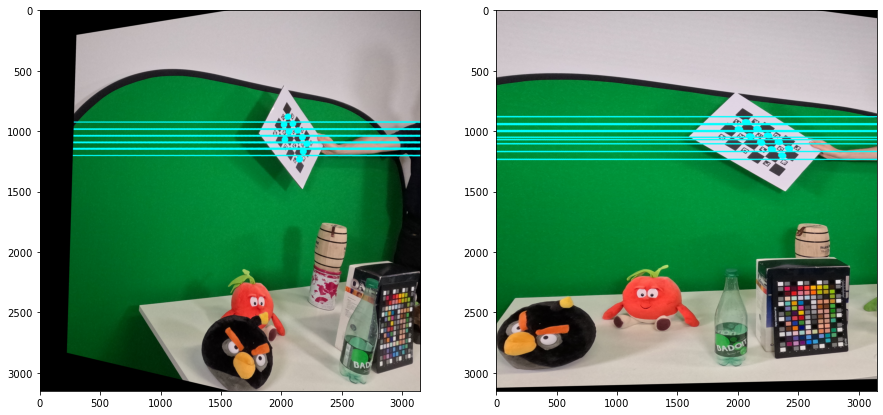

In [97]:
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    pts_front_L, 
    pts_left, 
    stereo_results['front-left'][-1], # fundamental matrix
    imsize
)

img_front_L_rect = cv2.warpPerspective(image_front_new, H1, imsize)
img_left_rect = cv2.warpPerspective(image_left_new, H2, imsize)

fig, axarr = plt.subplots(1,2, figsize=(15, 15))

axarr[0].imshow(cv2.warpPerspective(img_left_unrect, H2, imsize))
axarr[1].imshow(cv2.warpPerspective(img_front_unrect_L, H1, imsize))
plt.show()

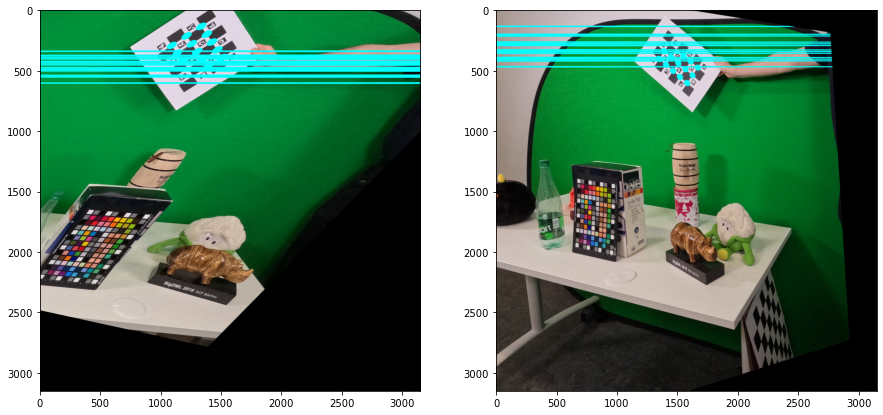

In [100]:
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    pts_front_R, 
    pts_right, 
    stereo_results['front-right'][-1], # fundamental matrix
    imsize
)

img_front_R_rect = cv2.warpPerspective(image_front_new, H1, imsize)
img_right_rect = cv2.warpPerspective(image_right_new, H2, imsize)

fig, axarr = plt.subplots(1,2, figsize=(15, 15))

axarr[0].imshow(cv2.warpPerspective(img_front_unrect_R, H1, imsize))
axarr[1].imshow(cv2.warpPerspective(img_right_unrect, H2, imsize))
plt.show()

### Disparity

In [41]:
block_size = 11
min_disp = -128
max_disp = 128
# Maximum disparity minus minimum disparity. The value is always greater than zero.
# In the current implementation, this parameter must be divisible by 16.
num_disp = max_disp - min_disp
# Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
# Normally, a value within the 5-15 range is good enough
uniquenessRatio = 5
# Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
# Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
speckleWindowSize = 200
# Maximum disparity variation within each connected component.
# If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
# Normally, 1 or 2 is good enough.
speckleRange = 2
disp12MaxDiff = 0
P1_sgbm=8 * 1 * block_size * block_size
P2_sgbm=32 * 1 * block_size * block_size

In [ ]:
# alternative setup for SGBM

min_disp = 16
num_disp = 96
block_size = 16
speckleWindowSize = 100
speckleRange = 32
disp12MaxDiff = 1
uniquenessRatio = 10
P1_sgbm=216
P2_sgbm=864

In [42]:
left_matcher = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=P1_sgbm,
    P2=P2_sgbm,
)

In [43]:
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)

# FILTER Parameters
lmbda = 80000
sigma = 1.2

wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)

In [44]:
def get_left_and_right_disparities(img_left, img_right, left_matcher, right_matcher, wls_filter):
    displ = left_matcher.compute(img_left, img_right)  
    dispr = right_matcher.compute(img_right, img_left)

    displ = np.int8(displ)
    dispr = np.int8(dispr)

    filtered_img_left = wls_filter.filter(displ, img_left, None, dispr)
    filtered_img_right = wls_filter.filter(dispr, img_right, None, displ)

    filtered_img_left = np.uint8(filtered_img_left + 128)
    filtered_img_right = np.uint8(filtered_img_right + 128)
    
    return filtered_img_left, filtered_img_right

In [45]:
img_left_rect_gray = cv2.cvtColor(img_left_rect, cv2.COLOR_BGR2GRAY)
img_front_L_rect_gray = cv2.cvtColor(img_front_L_rect, cv2.COLOR_BGR2GRAY)
img_front_R_rect_gray = cv2.cvtColor(img_front_R_rect, cv2.COLOR_BGR2GRAY)
img_right_rect_gray = cv2.cvtColor(img_right_rect, cv2.COLOR_BGR2GRAY)

In [138]:
disp_left, disp_front_L  = get_left_and_right_disparities(
    img_left_rect_gray, 
    img_front_L_rect_gray, 
    left_matcher, 
    right_matcher, 
    wls_filter
)

In [139]:
disp_front_R, disp_right = get_left_and_right_disparities(
    img_front_R_rect_gray, 
    img_right_rect_gray, 
    left_matcher, 
    right_matcher, 
    wls_filter
)

Normalizing for better visualization, may be skipped

In [140]:
disp_left_norm = np.clip(disp_left, 90, 170)
disp_front_L_norm = np.clip(disp_front_L, 90, 170)

disp_front_R_norm = np.clip(disp_front_R, 90, 170)
disp_right_norm = np.clip(disp_right, 90, 170)

In [141]:
disp_left_norm = cv2.normalize(disp_left_norm, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
disp_front_L_norm = cv2.normalize(disp_front_L_norm, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

disp_front_R_norm = cv2.normalize(disp_front_R_norm, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
disp_right_norm = cv2.normalize(disp_right_norm, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)


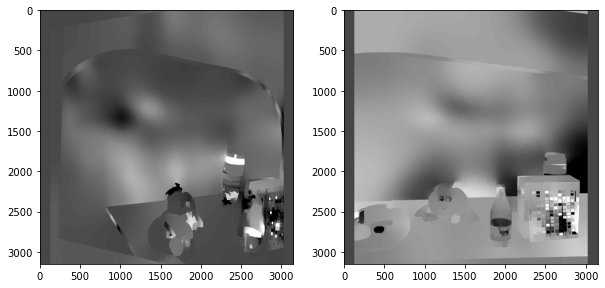

In [142]:
fig, axarr = plt.subplots(1,2, figsize=(10, 10))

axarr[0].imshow(disp_left_norm, cmap='gray')
axarr[1].imshow(disp_front_L_norm, cmap='gray')
plt.show()

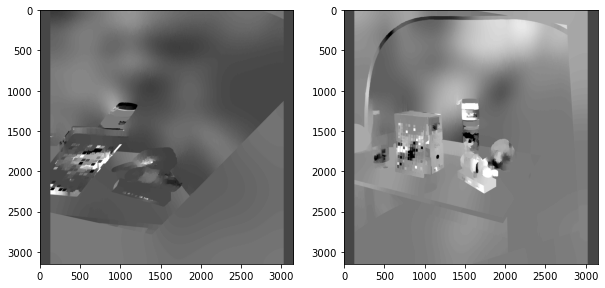

In [143]:
fig, axarr = plt.subplots(1,2, figsize=(10, 10))

axarr[0].imshow(disp_front_R_norm, cmap='gray')
axarr[1].imshow(disp_right_norm, cmap='gray')
plt.show()

### Point cloud and writing to a file

In [50]:
def write_ply(file_name, verts, colors):
    ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])

    verts = verts[~np.isnan(verts).any(axis=1)]
    verts = verts[~np.isinf(verts).any(axis=1)]

    with open(file_name, 'w') as file:
        file.write(ply_header % dict(vert_num=len(verts)))
        np.savetxt(file, verts, '%f %f %f %d %d %d')

In [127]:
Q_fr_alter = Q_fr.copy()
Q_fr_alter[3][3]=200

In [128]:
points_left = cv2.reprojectImageTo3D(disp_left, Q_fr_alter)
points_right = cv2.reprojectImageTo3D(disp_right, Q_fr_alter)
# points_left = cv2.reprojectImageTo3D(disp_left, Q_fl)
# points_right = cv2.reprojectImageTo3D(disp_right, Q_fr)

In [129]:
colors_left = image_left_new
colors_right = image_right_new

In [130]:
mask_l = disp_left > disp_left.min()
mask_r = disp_right > disp_right.min()

In [131]:
write_ply('r.ply', points_right[mask_r][::20], colors_right[mask_r][::20])

In [132]:
write_ply('l.ply', points_left[mask_l][::20], colors_left[mask_l][::20])

In [69]:
points_left = cv2.reprojectImageTo3D(disp_left, Q_fr_alter)
points_front_L = cv2.reprojectImageTo3D(disp_front_L, Q_fr_alter)

In [73]:
colors_left = image_left_new
colors_front = image_front_new

In [71]:
mask_l = disp_left > disp_left.min()
mask_f = disp_front_L > disp_front_L.min()

In [74]:
tmp_points = np.concatenate((points_left[mask_l], points_front_L[mask_f]), axis=0)
tmp_colors = np.concatenate((colors_left[mask_l], colors_front[mask_f]), axis=0)

In [75]:
write_ply('l_f_test.ply', tmp_points[::20], tmp_colors[::20])